In [1]:
%matplotlib inline

import gc
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import scipy as sp
import numpy as np

plt.style.use('seaborn-whitegrid')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def summarize(alpha=0.05):

    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })

    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index().drop('level_0', axis=1)
    merged = pd.merge(
        df, source_data[group_columns],
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )


**H1** Let’s revisit the Bangladesh fertility data, `bangladesh`, from the practice problems for Chapter 12. Fit a model with both varying intercepts by `district_id` and varying slopes of urban by `district_id`. You are still predicting `use.contraception`. 

In [3]:
data = pd.read_csv('../data/bangladesh.csv', sep=';')

districts = (data.district.drop_duplicates()
             .reset_index(drop=True).reset_index()
             .set_index('district')['index'].rename('district_i').to_frame())
num_districts = districts.shape[0]

data = pd.merge(data, districts, left_on='district', right_index=True)

data = data.assign(
    age_s = data['age.centered'] / data['age.centered'].std(),
    children = data['living.children'],
    using = data['use.contraception']
)

data = data[['district_i', 'age_s', 'children', 'urban', 'using']]

n_districts = data.district_i.nunique()

data.sample(5)

,district_i,age_s,children,urban,using
1582,47,-0.173068,4,0,1
1365,42,-1.504453,1,0,0
1512,45,0.936400,4,0,0
867,26,1.602087,4,0,0
720,20,-0.838755,2,0,0


In [4]:
data_agg = data.groupby(['district_i', 'urban', 'using']).using.count().unstack().fillna(0)
data_agg = data_agg.assign(
    total=(data_agg[0] + data_agg[1]).astype('int'),
    using=(data_agg[1]).astype('int'),
)[['total', 'using']]
data_agg = data_agg.reset_index()
data_agg.index.rename('ix', inplace=True)
data_agg.sample(5)

using,district_i,urban,total,using
ix,,,,
85,50,0,20,7
20,12,1,8,3
27,16,0,24,7
91,54,0,24,13
47,29,0,45,18


In [7]:
raw_p = data_agg.using.sum() / data_agg.total.sum()
raw_p

0.3924508790072389

In [8]:
with pm.Model() as m1:
    a = pm.Normal('a', mu=0, sd=1)
    
    K_district = pm.LKJCholeskyCov(
        'K_district', n=2, eta=1,
        sd_dist = pm.Exponential.dist(lam=1, shape=2)
    )
    district = pm.MvNormal(
        'district', mu=0,
        chol = pm.expand_packed_triangular(2, K_district),
        shape = (n_districts, 2)
    )

    district_a = pm.Deterministic('district_a', district[:, 0])
    district_urban = pm.Deterministic('district_urban', district[:, 1])

    p_i = pm.Deterministic(
        'p_i',
        pm.math.invlogit(
            sp.special.logit(raw_p)
            + a
            + district_a[data_agg.district_i.values]
            + district_urban[data_agg.district_i.values] * data_agg.urban.values
        )
    )

    obs = pm.Binomial('obs', n=data_agg.total.values, p=p_i,
                      observed=data_agg.using.values)

    m1.name = 'covariate districts'
    m1.trace = pm.sample(2000, tune=1500, chains=2)

/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a 

/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/pymc3/plots/forestplot.py:318: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/pymc3/plots/forestplot.py:319: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


GridSpec(1, 2, width_ratios=[3, 1])

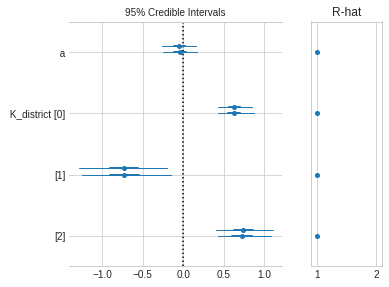

In [9]:
pm.forestplot(m1.trace, varnames=['a', 'K_district'])

Inspect the correlation between the
intercepts and slopes. Can you interpret this correlation, in terms of what it tells you about the pattern
of contraceptive use in the sample? It might help to plot the mean (or median) varying effect estimates
for both the intercepts and slopes, by district. Then you can visualize the correlation and maybe more
easily think through what it means to have a particular correlation. Plotting predicted proportion of
women using contraception, with urban women on one axis and rural on the other, might also help.


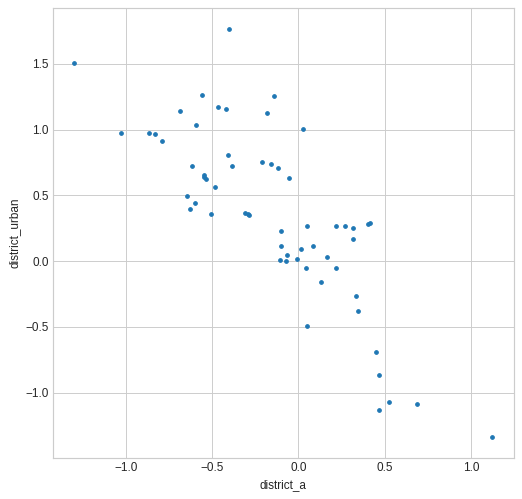

In [10]:
tr_d_a = m1.trace['district_a'].mean(axis=0)
tr_d_u = m1.trace['district_urban'].mean(axis=0)

plt.figure(figsize=(7, 7), dpi=85)

plt.scatter(tr_d_a, tr_d_u, marker='.')
plt.gca().set(xlabel='district_a', ylabel='district_urban')
None

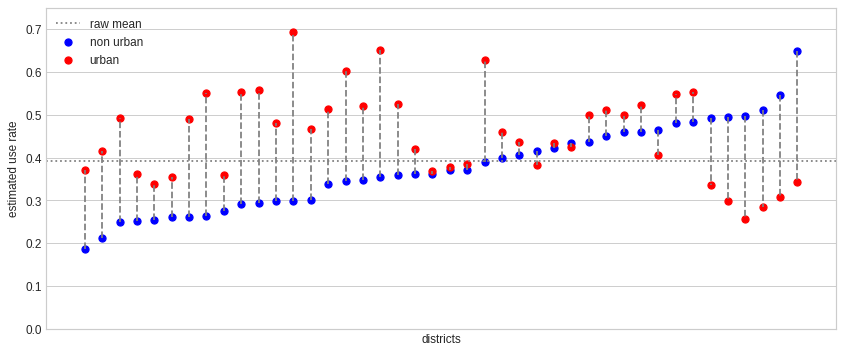

In [32]:
p_pred = (agg_prediction(m1.trace['p_i'], data_agg, ['district_i', 'urban'], summarize())
          .set_index(['district_i', 'urban'])
          .mean_.rename('p').to_frame())

p_pred = p_pred.unstack().dropna()
p_pred.columns = ['non_urban', 'urban']
p_pred = p_pred.sort_values('non_urban').reset_index(drop=True)

plt.figure(figsize=(12, 5), dpi=85)

plt.scatter(p_pred.index, p_pred.non_urban,
            marker='o', color='b', label='non urban')
plt.scatter(p_pred.index, p_pred.urban,
            marker='o', color='r', label='urban')

for ix, row in p_pred.iterrows():
    plt.plot((ix, ix), 
             (row.non_urban, row.urban), c='gray', linestyle='--')

plt.axhline(raw_p, linestyle=':', color='gray', label='raw mean')
    
plt.legend()
plt.gca().set(xticks=[], xlabel='districts', ylabel='estimated use rate',
              ylim=(0, .75))
None

*Conclusion*: Urban areas in districts have higher rates of usage, excepts in districts where the non-urban rate of usage is highest